ERP5 strategy:
How is it calculated?

 The ERP5 investment strategy finds undervalued companies based on the following four ratios:

    Earnings Yield = earnings per share
    Return on invested capital (ROIC) = netIncome/totalInvestments
    Price to Book = number of shares/Investments
    5 year average ROIC = 5 year avg roic_data

They named the strategy ERP5, based on the initials of the 4 factors ERP5.

To get the ERP5 ranking, all companies are ranked on each of the four ratios. These rankings are then added together to give the ERP5 value of the company.

In [1]:
import pandas as pd
from pandas.core.frame import DataFrame
from database import Database_Connector 
from functools import reduce
import numpy as np
import matplotlib.pyplot as plt


got the data from
```https://simfin.com/data/bulk```

1. earnings_latest.csv
2. us-balance-annual.csv
3. us-income-annual.csv

In [3]:


# caluclation of earnigs yield = earnings per share
eps_data = pd.read_csv('data/earnings_latest.csv')
eps_data_clean = eps_data[eps_data['eps'].notnull()]
eps_data_with_year = eps_data_clean.assign(year=lambda row: row['date'].apply(lambda x: x[0:4]))
eps_data_with_year = eps_data_with_year.rename(columns={'symbol':'Ticker'})
eps_data_2019_inter = eps_data_with_year.query('year=="2019"')
eps_data_2019_inter = eps_data_2019_inter.groupby('Ticker').aggregate({'eps': 'mean'})['eps']
eps_data_2019_inter = eps_data_2019_inter.multiply(4)

eps_data_2019_inter

Ticker
A       3.120000
AA     -0.020000
AAC    -1.350000
AAL     4.800000
AAN     3.760000
          ...   
ZUO    -0.370000
ZVO    -0.426667
ZYME   -1.730000
ZYNE   -1.490000
ZYXI    0.270000
Name: eps, Length: 4346, dtype: float64

In [4]:

# roic caluclation helper
capital_data = pd.read_csv('data/us-balance-annual.csv',sep=';')
profit_data = pd.read_csv('data/us-income-annual.csv',sep = ';')

roic_annual_data = DataFrame()
roic_annual_data['Ticker'] = capital_data['Ticker']  
roic_annual_data['Fiscal Year'] = capital_data['Fiscal Year']
roic_annual_data['Investments'] = capital_data['Total Assets'] - capital_data['Total Current Liabilities']
roic_annual_data = roic_annual_data.assign(Net_Income= lambda row: profit_data.loc[(profit_data['Ticker'] == row['Ticker']) 
                                            & (profit_data['Fiscal Year'] == row['Fiscal Year'])]
                                        ["Net Income"])
roic_annual_data['roic'] = roic_annual_data['Net_Income'] /roic_annual_data['Investments']

roic_annual_data

,Ticker,Fiscal Year,Investments,Net_Income,roic
0,A,2016,6849000000,462000000,0.067455
1,A,2017,7163000000,684000000,0.095491
2,A,2018,7370000000,316000000,0.042877
3,A,2019,7372000000,1071000000,0.145279
4,A,2020,8160000000,719000000,0.088113
...,...,...,...,...,...
10505,ZYXI,2015,-3843000,-2911000,0.757481
10506,ZYXI,2016,-3654000,69000,-0.018883
10507,ZYXI,2017,4902000,7365000,1.502448
10508,ZYXI,2018,12268000,9552000,0.778611


In [6]:

# book value Caluclation
def calucalte_book_value(ticker,year):
    shares = profit_data.loc[(profit_data['Ticker'] == ticker) & (profit_data['Fiscal Year'] == year)]['Shares (Basic)']
    investments = roic_annual_data.loc[(roic_annual_data['Ticker'] == ticker) & (roic_annual_data['Fiscal Year'] == year)]['Investments']
    return shares/investments


In [7]:

# roic into years and avg
roic_annual_data = roic_annual_data.assign(bvps = lambda row: calucalte_book_value(row['Ticker'],row['Fiscal Year'])) 
roic_5_avg_inter = roic_annual_data.groupby('Ticker').aggregate({'roic':'mean'})['roic']


In [8]:

# 1.eps 2020 = eps_data_2020
eps_data_2019 = DataFrame()
eps_data_2019['Ticker'] = eps_data_2019_inter.keys()
eps_data_2019['eps'] = eps_data_2019_inter.values

eps_data_2019

,Ticker,eps
0,A,3.120000
1,AA,-0.020000
2,AAC,-1.350000
3,AAL,4.800000
4,AAN,3.760000
...,...,...
4341,ZUO,-0.370000
4342,ZVO,-0.426667
4343,ZYME,-1.730000
4344,ZYNE,-1.490000


In [9]:

# 2.roic 2020 = roic_2020
roic_2019 = DataFrame()
roic_2019[['Ticker','roic']] = roic_annual_data.loc[roic_annual_data['Fiscal Year']== 2019][['Ticker','roic']]

roic_2019

,Ticker,roic
3,A,0.145279
9,AA,-0.093222
15,AAL,0.040447
20,AAMC,-0.056500
25,AAN,0.017986
...,...,...
10491,ZUMZ,0.088637
10494,ZUO,-0.352458
10499,ZVO,-0.432633
10504,ZYNE,-0.435149


In [10]:

# 3. Price to Book = book_price_2020
book_price_2019 = DataFrame()
book_price_2019[['Ticker','bvps']] = roic_annual_data.loc[roic_annual_data['Fiscal Year']== 2019][['Ticker','bvps']]

book_price_2019

,Ticker,bvps
3,A,0.042594
9,AA,0.015330
15,AAL,0.010636
20,AAMC,0.034379
25,AAN,0.043091
...,...,...
10491,ZUMZ,0.033397
10494,ZUO,0.469648
10499,ZVO,0.232781
10504,ZYNE,0.290599


In [11]:

# 4. previous 5 years roic avg = roic_5_avg
roic_5_avg = DataFrame()
roic_5_avg['Ticker'] = roic_5_avg_inter.keys()
roic_5_avg['roic_avg'] = roic_5_avg_inter.values

roic_5_avg

,Ticker,roic_avg
0,A,0.087843
1,AA,-0.029814
2,AAC_delist,-0.062675
3,AAL,0.079620
4,AAMC,-0.106678
...,...,...
2358,ZUMZ,0.082950
2359,ZUO,-0.563604
2360,ZVO,-0.130122
2361,ZYNE,-0.550843


In [12]:

# final data normalized and took all the data and took common components
final_data = DataFrame()
final_data['Ticker'] = roic_2019['Ticker']
final_data = pd.merge(roic_2019,eps_data_2019,on='Ticker',how="inner")
final_data = pd.merge(final_data,book_price_2019,on='Ticker',how="inner")
final_data = pd.merge(final_data,roic_5_avg,on='Ticker',how="inner")

final_data

,Ticker,roic,eps,bvps,roic_avg
0,A,0.145279,3.120000,0.042594,0.087843
1,AA,-0.093222,-0.020000,0.015330,-0.029814
2,AAL,0.040447,4.800000,0.010636,0.079620
3,AAN,0.017986,3.760000,0.043091,0.062024
4,AAOI,-0.175910,-0.700000,0.053220,0.037043
...,...,...,...,...,...
1810,ZUMZ,0.088637,2.320000,0.033397,0.082950
1811,ZUO,-0.352458,-0.370000,0.469648,-0.563604
1812,ZVO,-0.432633,-0.426667,0.232781,-0.130122
1813,ZYNE,-0.435149,-1.490000,0.290599,-0.550843


In [13]:

# now lets assign ranks individually
final_data['eps_rank'] = final_data['eps'].rank(method='min',ascending= False)
final_data['roic_rank'] = final_data['roic'].rank(method='min',ascending= False)
final_data['bvps_rank'] = final_data['bvps'].rank(method='min',ascending= False)
final_data['roic_avg_rank'] = final_data['roic_avg'].rank(method='min',ascending=False)
final_data = final_data.assign(rank_total = lambda row : row['eps_rank']
                                                        + row['roic_rank']
                                                        + row['bvps_rank']
                                                        + row['roic_avg_rank'])

final_data

,Ticker,roic,eps,bvps,roic_avg,eps_rank,roic_rank,bvps_rank,roic_avg_rank,rank_total
0,A,0.145279,3.120000,0.042594,0.087843,580.0,239.0,847.0,495.0,2161.0
1,AA,-0.093222,-0.020000,0.015330,-0.029814,1410.0,1465.0,1480.0,1336.0,5691.0
2,AAL,0.040447,4.800000,0.010636,0.079620,339.0,888.0,1625.0,549.0,3401.0
3,AAN,0.017986,3.760000,0.043091,0.062024,459.0,1103.0,837.0,702.0,3101.0
4,AAOI,-0.175910,-0.700000,0.053220,0.037043,1598.0,1547.0,685.0,925.0,4755.0
...,...,...,...,...,...,...,...,...,...,...
1810,ZUMZ,0.088637,2.320000,0.033397,0.082950,755.0,478.0,1009.0,526.0,2768.0
1811,ZUO,-0.352458,-0.370000,0.469648,-0.563604,1524.0,1635.0,107.0,1702.0,4968.0
1812,ZVO,-0.432633,-0.426667,0.232781,-0.130122,1535.0,1664.0,226.0,1487.0,4912.0
1813,ZYNE,-0.435149,-1.490000,0.290599,-0.550843,1682.0,1667.0,180.0,1700.0,5229.0


In [14]:

# data is done 
final_data = final_data.sort_values(by='rank_total')
companies_list = tuple(final_data.head(11)['Ticker'])
companies_list


('VRSN',
 'MED',
 'UI',
 'AAPL',
 'MA',
 'INTU',
 'IDXX',
 'NVDA',
 'FIZZ',
 'EAF',
 'DPZ')

In [15]:

# 1. 5 years - 2015 - 2015-01-02
# 1. 4 years - 2016 - 2016-01-04
# 1. 3 years - 2017 - 2017-01-03
# 1. 2 years - 2018 - 2018-01-02
# 1. 1 years - 2019 - 2019-01-02
# 2. present - 2020 - 2020-01-02

# Stock data_set columns 
stock_data_columns = ['Ticker','date','open','high','low','close','close_adjusted','volume','split_coefficient']
stock_2020 = DataFrame(Database_Connector().get_ticker_data(companies_list,'2020-01-02'),columns=stock_data_columns)[['Ticker','close_adjusted']]
stock_2019 = DataFrame(Database_Connector().get_ticker_data(companies_list,'2019-01-02'),columns=stock_data_columns)[['Ticker','close_adjusted']]
stock_2018 = DataFrame(Database_Connector().get_ticker_data(companies_list,'2018-01-02'),columns=stock_data_columns)[['Ticker','close_adjusted']]
stock_2017 = DataFrame(Database_Connector().get_ticker_data(companies_list,'2017-01-03'),columns=stock_data_columns)[['Ticker','close_adjusted']]
stock_2016 = DataFrame(Database_Connector().get_ticker_data(companies_list,'2016-01-04'),columns=stock_data_columns)[['Ticker','close_adjusted']]
stock_2015 = DataFrame(Database_Connector().get_ticker_data(companies_list,'2015-01-02'),columns=stock_data_columns)[['Ticker','close_adjusted']]


stock_2020

Connection to the PostgreSQL established successfully.
Data retrival for ('VRSN', 'MED', 'UI', 'AAPL', 'MA', 'INTU', 'IDXX', 'NVDA', 'FIZZ', 'EAF', 'DPZ') success
Connection to the PostgreSQL established successfully.
Data retrival for ('VRSN', 'MED', 'UI', 'AAPL', 'MA', 'INTU', 'IDXX', 'NVDA', 'FIZZ', 'EAF', 'DPZ') success
Connection to the PostgreSQL established successfully.
Data retrival for ('VRSN', 'MED', 'UI', 'AAPL', 'MA', 'INTU', 'IDXX', 'NVDA', 'FIZZ', 'EAF', 'DPZ') success
Connection to the PostgreSQL established successfully.
Data retrival for ('VRSN', 'MED', 'UI', 'AAPL', 'MA', 'INTU', 'IDXX', 'NVDA', 'FIZZ', 'EAF', 'DPZ') success
Connection to the PostgreSQL established successfully.
Data retrival for ('VRSN', 'MED', 'UI', 'AAPL', 'MA', 'INTU', 'IDXX', 'NVDA', 'FIZZ', 'EAF', 'DPZ') success
Connection to the PostgreSQL established successfully.
Data retrival for ('VRSN', 'MED', 'UI', 'AAPL', 'MA', 'INTU', 'IDXX', 'NVDA', 'FIZZ', 'EAF', 'DPZ') success


,Ticker,close_adjusted
0,MED,111.7300
1,MA,303.3900
2,NVDA,239.9100
3,FIZZ,48.6000
4,AAPL,300.3500
5,VRSN,196.7300
6,IDXX,265.0200
7,EAF,11.3900
8,DPZ,293.4000
9,INTU,265.6478


In [16]:

# normalizing all the sizes
ror_2020_temp = pd.merge(stock_2020,stock_2015,on='Ticker' , how='inner')
ror_2019_temp = pd.merge(stock_2019,stock_2015,on='Ticker' , how='inner')
ror_2018_temp = pd.merge(stock_2018,stock_2015,on='Ticker' , how='inner')
ror_2017_temp = pd.merge(stock_2017,stock_2015,on='Ticker' , how='inner')
ror_2016_temp = pd.merge(stock_2016,stock_2015,on='Ticker' , how='inner')

ror_2016_temp

,Ticker,close_adjusted_x,close_adjusted_y
0,AAPL,101.4181,103.4908
1,DPZ,107.0240,91.3223
2,FIZZ,40.4451,21.4082
3,INTU,92.0280,87.9577
4,NVDA,31.9405,19.5410
5,VRSN,83.9500,57.1900
6,IDXX,71.1200,73.6650
7,MA,93.2127,83.6407
8,MED,26.9896,30.1933


In [17]:

# finding actual ror
ror_2020 = ror_2020_temp.assign(ror_2020 = lambda row : row['close_adjusted_x']/row['close_adjusted_y'])
ror_2019 = ror_2019_temp.assign(ror_2019= lambda row : row['close_adjusted_x']/row['close_adjusted_y'])
ror_2018 = ror_2018_temp.assign(ror_2018 = lambda row : row['close_adjusted_x']/row['close_adjusted_y'])
ror_2017 = ror_2017_temp.assign(ror_2017 = lambda row : row['close_adjusted_x']/row['close_adjusted_y'])
ror_2016 = ror_2016_temp.assign(ror_2016 = lambda row : row['close_adjusted_x']/row['close_adjusted_y'])

ror_2016

,Ticker,close_adjusted_x,close_adjusted_y,ror_2016
0,AAPL,101.4181,103.4908,0.9799721327886150266497118584
1,DPZ,107.0240,91.3223,1.171937193872690460051925981
2,FIZZ,40.4451,21.4082,1.889234031819583150381629469
3,INTU,92.0280,87.9577,1.046275652955909488310858515
4,NVDA,31.9405,19.5410,1.634537638810705695716698224
5,VRSN,83.9500,57.1900,1.467913970973946494142332576
6,IDXX,71.1200,73.6650,0.9654517070521957510350912917
7,MA,93.2127,83.6407,1.114441892523615895132393679
8,MED,26.9896,30.1933,0.8938936783988500760102406825


In [18]:

# dropping unessary values
ror_2020 = ror_2020.drop(columns=['close_adjusted_x','close_adjusted_y'])
ror_2019 = ror_2019.drop(columns=['close_adjusted_x','close_adjusted_y'])
ror_2018 = ror_2018.drop(columns=['close_adjusted_x','close_adjusted_y'])
ror_2017 = ror_2017.drop(columns=['close_adjusted_x','close_adjusted_y'])
ror_2016 = ror_2016.drop(columns=['close_adjusted_x','close_adjusted_y'])

ror_2016

,Ticker,ror_2016
0,AAPL,0.9799721327886150266497118584
1,DPZ,1.171937193872690460051925981
2,FIZZ,1.889234031819583150381629469
3,INTU,1.046275652955909488310858515
4,NVDA,1.634537638810705695716698224
5,VRSN,1.467913970973946494142332576
6,IDXX,0.9654517070521957510350912917
7,MA,1.114441892523615895132393679
8,MED,0.8938936783988500760102406825


In [19]:

data_frames = [ror_2016,ror_2017,ror_2018,ror_2019,ror_2020]

ror_data = reduce(lambda left,right: pd.merge(left,right,on=['Ticker'],how='inner'),data_frames)

# rounding of ror for every Data
ror_data = ror_data.astype({'ror_2020':'float',
                            'ror_2019':'float',
                            'ror_2018':'float',
                            'ror_2017':'float',
                            'ror_2016':'float'}).round(decimals=5)

ror_data

,Ticker,ror_2016,ror_2017,ror_2018,ror_2019,ror_2020
0,AAPL,0.97997,1.10448,1.66450,1.51942,2.90219
1,DPZ,1.17194,1.71751,2.04704,2.66419,3.21280
2,FIZZ,1.88923,2.33890,4.58609,3.39963,2.27016
3,INTU,1.04628,1.28719,1.80024,2.20583,3.02018
4,NVDA,1.63454,5.20025,10.20163,6.97098,12.27726
5,VRSN,1.46791,1.35181,1.91415,2.58367,3.43994
6,IDXX,0.96545,1.59642,2.14227,2.47689,3.59764
7,MA,1.11444,1.24885,1.81337,2.26463,3.62730
8,MED,0.89389,1.35372,2.40153,4.19398,3.70049


In [20]:
years = ['2016','2017','2018','2019','2020']

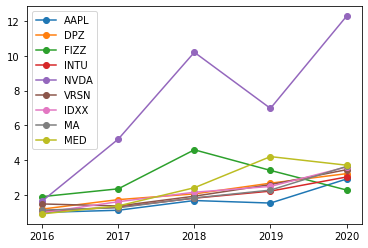

In [21]:
fig, ax = plt.subplots(1)
for ticker in ror_data['Ticker'].tolist():
    data = ror_data.loc[ror_data['Ticker'] == ticker].drop(columns=['Ticker']).values.tolist()[0]
    plt.plot(years,data,"-o",label=ticker)
plt.legend()
plt.show()

In [22]:
average_ror = ror_data.mean(numeric_only=True)
average_ror


ror_2016    1.240406
ror_2017    1.911014
ror_2018    3.174536
ror_2019    3.142136
ror_2020    4.227551
dtype: float64

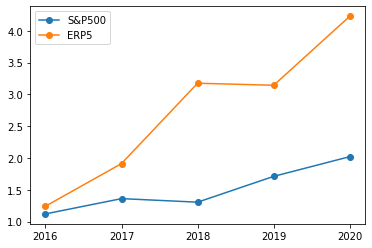

In [ ]:
# 2016	11.96%
# 2017	21.83%
# 2018	-4.38%
# 2019	31.49%
# 2020	18.40%
s_and_p_cumulative_avg= [1.1196,1.36,1.3042,1.71,2.02]

plt.plot(years,s_and_p_cumulative_avg,"-o",label='S&P500')
plt.plot(years,average_ror,"-o",label='ERP5')
plt.legend()
plt.show()